In [1]:
!pip install hmmlearn
!pip install matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from hmmlearn.hmm import GaussianHMM
from pandas_datareader.data import DataReader
import yfinance as yf

In [2]:
start_date = "2014-09-17"
end_date = "2025-12-31"
symbol = "BTC-USD"

data = yf.download(symbol, start=start_date, end=end_date)

if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.droplevel(1)
data.tail(3)
print(len(data))

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

3831


In [3]:
# Copy data to a new DataFrame
df = data.copy()

df["Returns"] = (df["Close"] / df["Close"].shift(1)) - 1
df["Range"] = (df["High"] / df["Low"]) - 1
df.dropna(inplace=True)

# Define the RSI function
def calculate_rsi(df, window=4):
    # Calculate daily price changes
    delta = df["Close"].diff()

    # Separate gains and losses
    gain = (delta.where(delta > 0, 0))
    loss = (-delta.where(delta < 0, 0))

    # Calculate the rolling average of gains and losses
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    # Compute the relative strength (RS)
    rs = avg_gain / avg_loss

    # Compute RSI
    rsi = 100 - (100 / (1 + rs))
    
    # Add RSI to the DataFrame
    df["RSI"] = rsi
    df = df.dropna(subset=["RSI"])
    return df

# Add RSI to the DataFrame
df = calculate_rsi(df)

# Prepare features
X_train = df[["Returns", "RSI"]]
print(X_train.head())


Price        Returns        RSI
Date                           
2014-09-19 -0.069843   0.000000
2014-09-20  0.035735  32.245377
2014-09-21 -0.024659  26.206007
2014-09-22  0.008352  30.505895
2014-09-23  0.083647  83.514028


In [4]:
# Ensure train-test split is done chronologically
split_point = int(len(X_train) * 0.75)  # 75% train, 25% test

# Split the data correctly ensuring no data leakage
X_train, X_test = X_train.iloc[:split_point], X_train.iloc[split_point:]

# Train the model on the training set
model = GaussianHMM(n_components=2, covariance_type="full", n_iter=100).fit(X_train)

# Evaluate the model
train_score = model.score(X_train)
test_score = model.score(X_test)

print("Training set model score:", train_score)
print("Test set model score:", test_score)

# Predict hidden states for the training set
hidden_states = model.predict(X_train.values)
hidden_states_series = pd.Series(hidden_states, index=X_train.index)  # Assign index for correct tracking

print("HMM column value counts:")
print(hidden_states_series.value_counts())

# Predict hidden states for the test set
hidden_states_test = model.predict(X_test.values)
hidden_states_test_series = pd.Series(hidden_states_test, index=X_test.index)  # Assign index for correct tracking

print("Test set HMM column value counts:")
print(hidden_states_test_series.value_counts())

Training set model score: -7484.689736299387
Test set model score: -2311.261726751572
HMM column value counts:
0    1602
1    1269
Name: count, dtype: int64
Test set HMM column value counts:
0    571
1    387
Name: count, dtype: int64


In [10]:
# Ensure that prices are correctly aligned with the test data
prices_test = df.loc[X_test.index, "Close"].values.astype(float)

labels_0 = []
labels_1 = []

# Iterate over test states and corresponding prices
for i, s in enumerate(hidden_states_test_series):
    if s == 0:
        labels_0.append(prices_test[i])
        labels_1.append(float('nan'))
    elif s == 1:
        labels_0.append(float('nan'))
        labels_1.append(prices_test[i])


In [11]:
# Map states to desired values
state_mapping = {
    0: 1,  # Replace state 0 with 1
    1: 0,  # Replace state 1 with 0
}

# Apply mapping to test data
remapped_states_test = [state_mapping[state] for state in hidden_states_test_series]

# Assign the remapped states only to the test data portion of the DataFrame
df.loc[X_test.index, "HMM"] = remapped_states_test

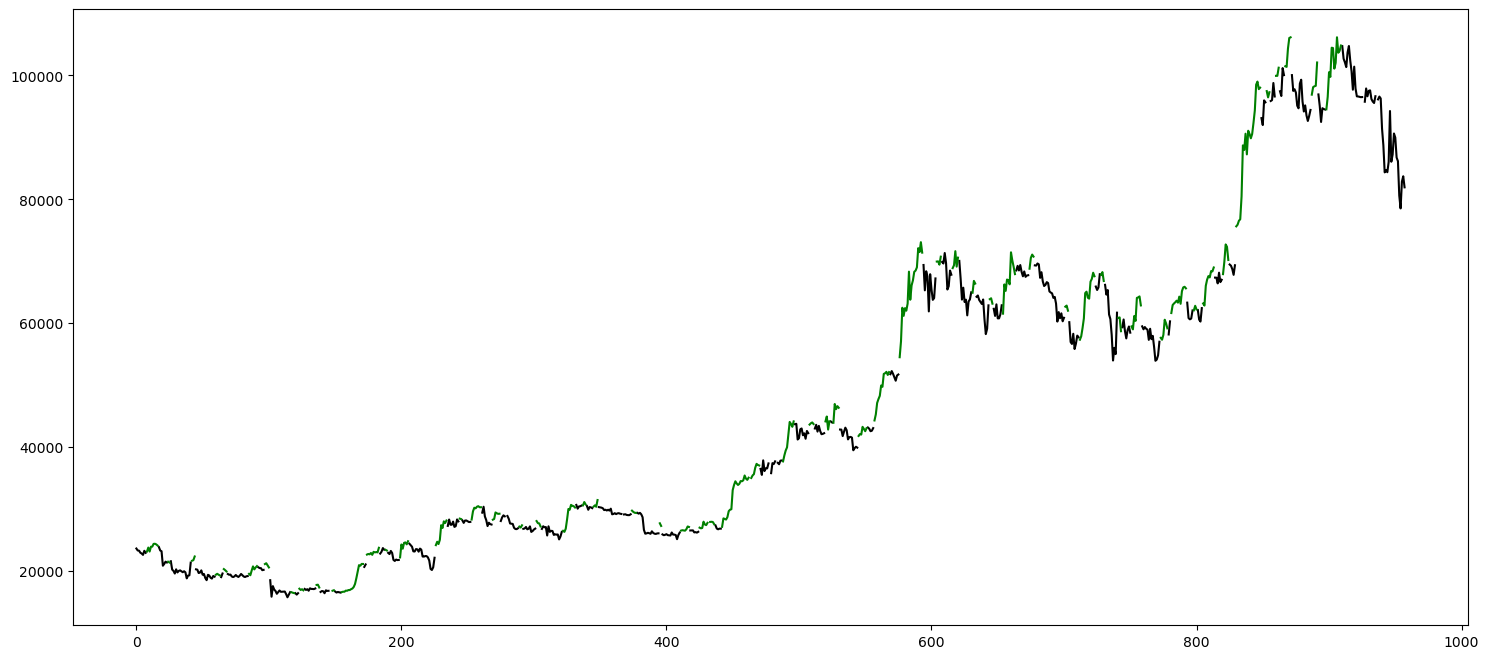

In [13]:
fig = plt.figure(figsize = (18, 8))
plt.plot(labels_0, color="black")
plt.plot(labels_1, color="green")
plt.show()


In [8]:
# Assuming hidden_states_test is the array of predicted states for the test data
print("Last 30 states of the test data:")
print(hidden_states_test[-30:])


Last 30 states of the test data:
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [9]:
# Sort X_test by index (date) to ensure proper chronological order
X_test_sorted = X_test.sort_index()

# Extract the last 30 test samples with their dates and states
last_30_test_states = pd.DataFrame({
    "Date": X_test_sorted.index[-30:],  # Get last 30 dates (now sorted)
    "State": hidden_states_test_series.loc[X_test_sorted.index[-30:]].values  # Get corresponding states
})

# Print in a readable format
print("Last 30 test dates with their corresponding states:")
for _, row in last_30_test_states.iterrows():
    print(f"Date: {row['Date']}, State: {int(row['State'])}")  # Convert state to int for clarity


Last 30 test dates with their corresponding states:
Date: 2025-02-12 00:00:00, State: 0
Date: 2025-02-13 00:00:00, State: 0
Date: 2025-02-14 00:00:00, State: 0
Date: 2025-02-15 00:00:00, State: 0
Date: 2025-02-16 00:00:00, State: 0
Date: 2025-02-17 00:00:00, State: 0
Date: 2025-02-18 00:00:00, State: 0
Date: 2025-02-19 00:00:00, State: 0
Date: 2025-02-20 00:00:00, State: 1
Date: 2025-02-21 00:00:00, State: 0
Date: 2025-02-22 00:00:00, State: 0
Date: 2025-02-23 00:00:00, State: 0
Date: 2025-02-24 00:00:00, State: 0
Date: 2025-02-25 00:00:00, State: 0
Date: 2025-02-26 00:00:00, State: 0
Date: 2025-02-27 00:00:00, State: 0
Date: 2025-02-28 00:00:00, State: 0
Date: 2025-03-01 00:00:00, State: 0
Date: 2025-03-02 00:00:00, State: 0
Date: 2025-03-03 00:00:00, State: 0
Date: 2025-03-04 00:00:00, State: 0
Date: 2025-03-05 00:00:00, State: 0
Date: 2025-03-06 00:00:00, State: 0
Date: 2025-03-07 00:00:00, State: 0
Date: 2025-03-08 00:00:00, State: 0
Date: 2025-03-09 00:00:00, State: 0
Date: 2025-0

In [14]:
print(df.loc[X_test.index, "Close"].head())
print(prices_test[:5])  # Should match the above


Date
2022-07-30    23656.207031
2022-07-31    23336.896484
2022-08-01    23314.199219
2022-08-02    22978.117188
2022-08-03    22846.507812
Name: Close, dtype: float64
[23656.20703125 23336.89648438 23314.19921875 22978.1171875
 22846.5078125 ]


In [15]:
print("First 10 values of labels_0:", labels_0[:10])
print("First 10 values of labels_1:", labels_1[:10])


First 10 values of labels_0: [23656.20703125, 23336.896484375, 23314.19921875, 22978.1171875, 22846.5078125, 22630.95703125, 23289.314453125, 22961.279296875, nan, nan]
First 10 values of labels_1: [nan, nan, nan, nan, nan, nan, nan, nan, 23175.890625, 23809.486328125]
